In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [38]:
def returns(tickers,s,e):
    df=yf.download(tickers,s,e)
    price=df['Adj Close']
    ret=price/price.shift(1)-1
    ret.dropna(inplace=True)
    return ret
def cum_returns(tickers,s,e,w):
    cum_sums=returns(tickers,s,e).cumsum()
    return cum_sums.iloc[-1,:].values*w
def random_weights(tickers):
    n=len(tickers)
    weights=np.random.random(n)
    normalized=weights/sum(weights)
    return normalized
def portfolio_return(tickers,s,e):
    random_weights(tickers)*data_collect(tickers,s,e)

In [32]:
tickers=['AAPL','MSFT','NVDA']
start='2021-01-01'
end='2023-04-27'
ret=returns(tickers,start,end)
weights=random_weights(tickers)

[*********************100%***********************]  3 of 3 completed


In [33]:
returns=cum_returns(tickers,start,end,weights)
total_return=np.sum(returns)
total_return

[*********************100%***********************]  3 of 3 completed


0.5002255856653758

In [40]:
def portfolio_risk(tickers,start,end,w):
    rets=returns(tickers,start,end)
    cov=rets.cov()
    n=len(rets)
    return np.sqrt(np.dot(w.T,np.dot(cov*n,w)))
risk=portfolio_risk(tickers,start,end,weights)

[*********************100%***********************]  3 of 3 completed


In [45]:
prets=[]
pvols=[]
rets=returns(tickers,start,end)
cum_sums=rets.cumsum().iloc[-1,:].values
cov=rets.cov()
n=len(rets)
for _ in range(500):
    w=random_weights(tickers)
    ret=np.sum(cum_sums*w)
    vol=np.sqrt(np.dot(w.T,np.dot(cov*n,w)))
    prets.append(ret)
    pvols.append(vol)
prets = np.array(prets)
pvols = np.array(pvols)

[*********************100%***********************]  3 of 3 completed


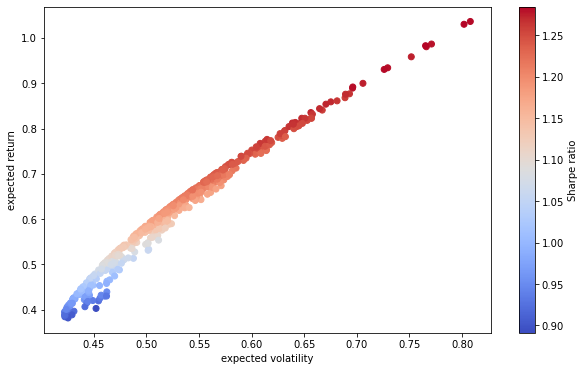

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [62]:
#Optimization
import scipy.optimize as sco
def p_ret(w):
    return np.sum(cum_sums*w)
def p_vol(w):
    return np.sqrt(np.dot(w.T,np.dot(cov*n,w)))
def min_sharpe(w):
    return -p_ret(w)/p_vol(w)
bnds=tuple((0,1) for _ in range(len(tickers)))
cons={'type': 'eq', 'fun':lambda x: np.sum(x)-1}
w0=np.array([1/len(tickers) for _ in range(len(tickers))])
opts=sco.minimize(min_sharpe, w0, method='SLSQP',
                   bounds=bnds,constraints=cons)

In [64]:
optv = sco.minimize(p_vol, w0,method='SLSQP', 
                    bounds=bnds,constraints=cons)

In [65]:
opts

     fun: -1.2854810115497124
     jac: array([ 6.40853196e-02,  2.63303518e-05, -3.81469727e-06])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.72920485e-17, 1.26679248e-01, 8.73320752e-01])

In [66]:
optv

     fun: 0.42108963795615034
     jac: array([0.42108922, 0.42109   , 0.60806842])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.46562826, 0.53437174, 0.        ])

In [57]:
p_ret(opts['x'])

0.9827697772488238

In [58]:
p_vol(opts['x'])

0.7645152035844116

In [59]:
p_ret(opts['x'])/p_vol(opts['x'])

1.2854810115497124

In [81]:
#Minimize volatility
targ_rets=np.linspace(0.38,1.04,50)
cons2=({'type':'eq','fun':lambda x: p_ret(x)-targ_ret},
       {'type':'eq','fun':lambda x: np.sum(x)-1})
targ_vols=[]
for targ_ret in targ_rets:
    res=sco.minimize(p_vol,w0,method='SLSQP',
                    bounds=bnds,constraints=cons2)
    targ_vols.append(res['fun'])
targ_vols=np.array(targ_vols)

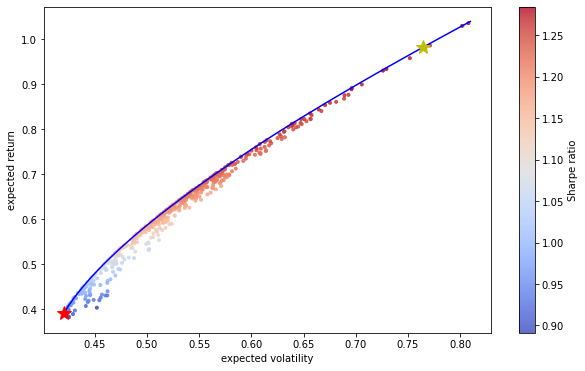

In [84]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(targ_vols, targ_rets, 'b', lw=1.50)
plt.plot(p_vol(opts['x']), p_ret(opts['x']),
'y*', markersize=15.0)
plt.plot(p_vol(optv['x']), p_ret(optv['x']),
'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [87]:
#Combination of risky and riskless assets
import scipy.interpolate as sci
common_ind=np.argmin(targ_vols)
erets=targ_rets[common_ind:]
evols=targ_vols[common_ind:]
tck=sci.splrep(evols,erets)
def f(x):
    return sci.splev(x,tck,der=0)
def df(x):
    return sci.splev(x,tck,der=1)
def equations(pars,rf=0.01):
    eq1 = pars[0] - rf
    eq2 = pars[0]+pars[1]*pars[2] - f(pars[2])
    eq3 = pars[1] - df(pars[2])
    return eq1, eq2, eq3
opt = sco.fsolve(equations, [0.01,0.42,1.1])

In [88]:
opt

array([0.01      , 1.27254193, 0.78139952])

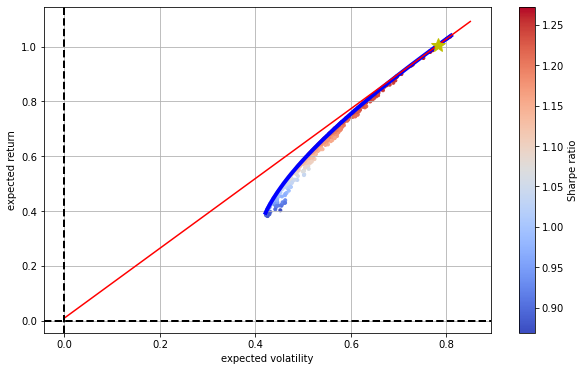

In [90]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols,
marker='.', cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)
cx = np.linspace(0, 0.85)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [91]:
cons=({'type':'eq','fun': lambda x: p_ret(x)-f(opt[2])},
     {'type':'eq', 'fun': lambda x: np.sum(x)-1})
res=sco.minimize(p_vol,w0,bounds=bnds, constraints=cons)
res

     fun: 0.7813995223753989
     jac: array([0.30945334, 0.32605518, 0.82801881])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([5.55111512e-17, 9.28738348e-02, 9.07126165e-01])

In [92]:
p_ret(res['x'])

1.0043636517079224

In [93]:
p_vol(res['x'])

0.7813995223753989

In [94]:
p_ret(res['x'])/p_vol(res['x'])

1.285339474811462